# Problem Set 1: Edges and Lines
---
## Setup

In [1]:
# IPython magic
%load_ext autoreload
%autoreload 2
# Matplotlib magic
%matplotlib inline

In [2]:
# Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
# Matplotlib params
plt.rcParams['figure.figsize'] = (14.0, 6.0)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
# Change to True if Jupyter Widgets extension is installed
IS_INTERACTIVE = True
# Turn widgets on-off
if IS_INTERACTIVE:
    from ipywidgets import interact
else:
    def interact(**kwargs):
        def decorator(f):
            return f()
        return decorator

---
## 1. Edge Operator

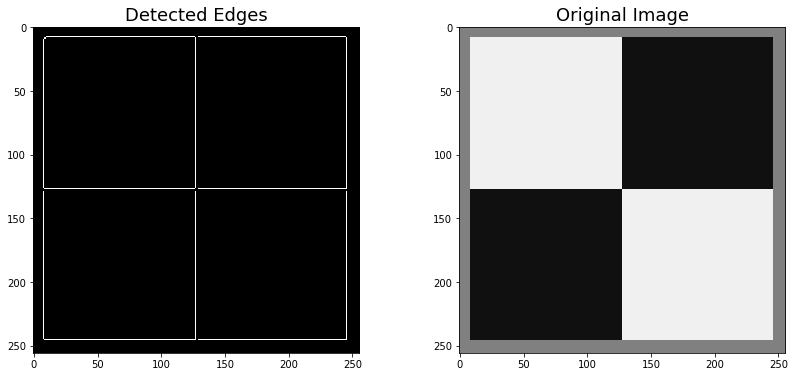

In [4]:
# Load image
img1 = cv2.imread('ps1-input0.png')
# OpenCV BGR to RGB
img1 = img1[:,:,::-1]
# Edge Detection
img1_edges = cv2.Canny(img1, 100, 200)
# Plot
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Detected Edges')
ax[0].imshow(img1_edges)
ax[1].set_title('Original Image')
ax[1].imshow(img1);

---
## 2. Hough Line Detector

In [79]:
def houghlines(img,rho_res=1.0,theta_res=np.pi/180,thresh=100):
    num_theta = int(np.pi / theta_res)
    rho_min = -img.shape[1]
    rho_max = np.sqrt(img.shape[0] ** 2 + img.shape[1] ** 2)
    num_rho = int((rho_max - rho_min) / rho_res)
    accum = np.zeros((num_rho, num_theta))
    for y, row in enumerate(img):
        for x, val in enumerate(row):
            if val > 0:
                for theta_ix in range(num_theta):
                    theta = theta_ix * theta_res
                    d = x*np.cos(theta) + y*np.sin(theta)
                    d_ix = int((d - rho_min) / rho_res)
                    accum[d_ix, theta_ix] += 1
    indices = np.argwhere(accum > thresh)
    lines = [(rho_min + rho_ix*rho_res, theta_ix*theta_res) for rho_ix, theta_ix in indices]
    return lines, accum

def get_line_points(rho, theta, xrange, yrange=0):
    if np.sin(theta):
        fx = (rho - xrange*np.cos(theta)) / np.sin(theta)
        return xrange, fx
    else:
        fy = (rho - yrange*np.sin(theta)) / np.cos(theta)
        return fy, yrange
    
def plot_hough_result(img, lines, accum):
    fig, ax = plt.subplots(1, 2)
    # Get rho range
    rho_min = -img.shape[1]
    rho_max = np.sqrt(img.shape[0] ** 2 + img.shape[1] ** 2)
    # Lines
    ax[0].imshow(img)
    ax[0].set_title('Detected Lines')
    # Fix x,y axes
    ax[0].set_ylim(img.shape[0], 0)
    ax[0].set_xlim(0, img.shape[1])
    xrange = range(img.shape[1])
    yrange = range(img.shape[0])
    # Plot each line
    for rho, theta in lines:
        ax[0].plot(*get_line_points(rho, theta, xrange, yrange), 'g')
    # Accumulator
    im = ax[1].imshow(accum, aspect='auto', origin='lower', extent=[0, 180, rho_min, rho_max])
    ax[1].set_title('Accumulator')
    # Create colorbar
    plt.colorbar(im)

In [77]:
@interact(rho_res=(1, 10), thresh=(100, 500))
def img1_hough(rho_res=1.0, thresh=200):
    # Find lines
    lines, accum = houghlines(img1_edges, rho_res=rho_res, thresh=thresh)
    # Plot
    plot_hough_result(img1, lines, accum)

interactive(children=(IntSlider(value=1, description='rho_res', max=10, min=1), IntSlider(value=200, descripti…

---
## 3. Edge Detection with Noise

In [10]:
#### Load Noisy image
img1n = cv2.imread('ps1-input0-noise.png')

### a. Gaussian Filter

In [11]:
@interact(ksize=(1,25,2), sigma=(0.1,5.0,0.1))
def img1_gaussian_blur(ksize=13, sigma=4.2):
    global img1n_blur
    # Add blur
    img1n_blur = cv2.GaussianBlur(img1n, (ksize, ksize), sigma)
    # Plot
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img1n_blur)
    ax[0].set_title('Smoothed Image')
    ax[1].imshow(img1n)
    ax[1].set_title('Original Image')

interactive(children=(IntSlider(value=13, description='ksize', max=25, min=1, step=2), FloatSlider(value=4.2, …

### b. Edge Operator

In [21]:
@interact(thresh1_low=(0,255), thresh1_high=(0,255))
def img1_canny(thresh1_low=50, thresh1_high=65):
    global img1n_blur_edges
    # Canny edge operator
    img1n_blur_edges = cv2.Canny(img1n_blur, thresh1_low, thresh1_high)
    img1n_edges = cv2.Canny(img1n, 50, 65)
    # Plot
    fig, ax = plt.subplots(1, 2)
    fig.suptitle('Edge Detection')
    ax[0].imshow(img1n_blur_edges)
    ax[0].set_title('Smoothed Image')
    ax[1].imshow(img1n_edges)
    ax[1].set_title('Original Image')

interactive(children=(IntSlider(value=50, description='thresh1_low', max=255), IntSlider(value=65, description…

### c. Hough Line detection

In [52]:
@interact(rho_res=(1, 10), theta_res=(np.pi/180, np.pi/30, np.pi/180), thresh=(50, 400))
def img1n_hough(rho_res=2.0, theta_res=np.pi/180, thresh=130):
    # Find lines
    lines, accum = houghlines(img1n_blur_edges, rho_res=rho_res, theta_res=theta_res, thresh=thresh)
    # Plot
    plot_hough_result(img1n, lines, accum)

interactive(children=(IntSlider(value=2, description='rho_res', max=10, min=1), FloatSlider(value=0.0174532925…

---
## 4. Edge Detection: Second Image

In [14]:
#### Load Noisy image
img2 = cv2.imread('ps1-input1.jpg')

### a. Gaussian Filter

In [15]:
@interact(ksize=(1,25,2), sigma=(0.1,5.0,0.1))
def img2_gaussian_blur(ksize=11, sigma=3.0):
    global img2_blur
    # Add blur
    img2_blur = cv2.GaussianBlur(img2, (ksize, ksize), sigma)
    # Plot
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img2_blur)
    ax[0].set_title('Smoothed Image')
    ax[1].imshow(img2)
    ax[1].set_title('Original Image')

interactive(children=(IntSlider(value=11, description='ksize', max=25, min=1, step=2), FloatSlider(value=3.0, …

### b. Edge Operator

In [16]:
@interact(thresh1_low=(0,255), thresh1_high=(0,255))
def img2_canny(thresh1_low=50, thresh1_high=100):
    global img2_edges
    # Canny edge operator
    img2_edges = cv2.Canny(img2_blur, thresh1_low, thresh1_high)
    # Plot
    plt.imshow(img2_edges)

interactive(children=(IntSlider(value=50, description='thresh1_low', max=255), IntSlider(value=100, descriptio…

### c. Hough Line detection

In [80]:
@interact(rho_res=(1, 10), theta_res_deg=(0.5, 20.0, 0.5), thresh=(50, 200))
def img2_hough(rho_res=2.0, theta_res_deg=1.0, thresh=130):
    # Find lines
    lines, accum = houghlines(img2_edges, rho_res=rho_res, theta_res=theta_res_deg * np.pi/180, thresh=thresh)
    # Plot
    plot_hough_result(img2, lines, accum)

interactive(children=(IntSlider(value=2, description='rho_res', max=10, min=1), FloatSlider(value=1.0, descrip…

---
## 5. Hough Circle Detection

---
## 6. Clutter Image

### a. Line Detection

### b. Problems

### c. Finding boundaries of pen

---
## 7. Clutter Image: Circles
### a. Hough circle detector

### b. False Alarms

---
## 8. Distorted Image

### a. Line and Circle Detection

### b. Problems

### c. Fixing Circle problem